In [ ]:
import sys

print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [ ]:
! pip uninstall tensorflow==2.17.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
y
  Successfully uninstalled tensorflow-2.17.1


In [ ]:
!pip install tensorflow==2.8.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 32.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

# Model 2: Multivariate-5-RNN









In [ ]:
import sys
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
print(tf.__version__)


2.8.4


In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'hpg.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Close,1.000000
Open,0.999645
High,0.999852
Low,0.999825
Volume,0.520064


count    4.237000e+03
mean     1.693428e+07
std      1.445787e+07
min      1.690000e+03
25%      6.130000e+06
50%      1.324000e+07
75%      2.344000e+07
max      1.743500e+08
Name: Volume, dtype: float64


<Axes: >

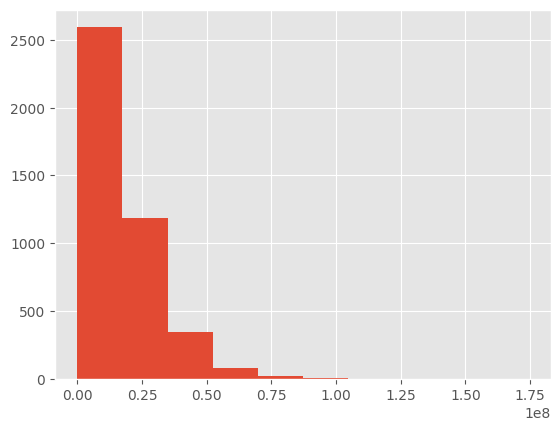

In [ ]:
# Distribution of Various Features
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df['Volume'].hist(bins = 10)

In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
print(df.head())

             Close    Open    High     Low      Volume  CMA10  SMA10  SMA50  \
Date                                                                          
2007-11-16  2530.0  2530.0  2530.0  2530.0   8390000.0    NaN    NaN    NaN   
2007-11-19  2404.5  2404.5  2404.5  2404.5   4070000.0    NaN    NaN    NaN   
2007-11-20  2300.0  2300.0  2300.0  2300.0   1980000.0    NaN    NaN    NaN   
2007-11-21  2383.6  2195.4  2383.6  2195.4  24590000.0    NaN    NaN    NaN   
2007-11-22  2383.6  2383.6  2383.6  2383.6   8980000.0    NaN    NaN    NaN   

                  EMA12        EMA26       MACD  RSI  CCI  %K  %D  
Date                                                               
2007-11-16  2530.000000  2530.000000   0.000000  NaN  NaN NaN NaN  
2007-11-19  2510.692308  2520.703704 -10.011396  NaN  NaN NaN NaN  
2007-11-20  2478.278107  2504.355281 -26.077175  NaN  NaN NaN NaN  
2007-11-21  2463.712244  2495.410446 -31.698202  NaN  NaN NaN NaN  
2007-11-22  2451.387283  2487.128190 -

## Train model

In [ ]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_2(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Evaluate Model

In [ ]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart

In [ ]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## Model building

In [ ]:
# Extracting the series
series = df[['Close','High','Low' , 'RSI', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4225, 5)
              Close     High      Low        RSI        MACD
Date                                                        
2024-11-12  27500.0  27900.0  27300.0  67.796610  199.382390
2024-11-13  27050.0  27400.0  26850.0  58.823529  187.405708
2024-11-14  26300.0  27100.0  26300.0  48.192771  116.057530
2024-11-15  25900.0  26350.0  25900.0  40.000000   26.926535
2024-11-18  25800.0  26050.0  25550.0  34.567901  -51.189504


In [ ]:
series.describe()

,Close,High,Low,RSI,MACD
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000
mean,10281.639621,10423.328308,10151.792213,52.165814,40.200131
std,10456.378500,10605.237877,10331.643686,18.159831,415.290658
min,756.300000,762.600000,756.300000,0.000000,-2162.781226
25%,1954.500000,1979.900000,1933.300000,38.546713,-50.521839
50%,5118.400000,5158.100000,5040.300000,52.535631,21.720429
75%,15057.900000,15309.300000,14781.400000,66.177452,126.946500
max,43895.800000,44198.500000,43517.400000,100.000000,2457.070901


In [ ]:

# Splitting dataset by row counts
train_data = series.iloc[:2969]
val_data = series.iloc[2970:3597]
test_data = series.iloc[3598:]

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(2969, 5) (627, 5) (627, 5)


,Close,High,Low,RSI,MACD
Date,,,,,
2007-12-05,2174.5,2195.4,2153.6,20.682830,-86.863564
2007-12-06,2195.4,2237.2,2195.4,23.325893,-86.194207
2007-12-07,2132.7,2174.5,2132.7,25.921332,-89.689221
2007-12-10,2038.6,2090.9,2038.6,26.407942,-98.911933
2007-12-11,1944.5,1975.9,1944.5,11.107174,-112.517056


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2969, 5) (627, 5) (627, 5)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 149: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 149: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 116: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 116: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 183: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 183: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 96: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 96: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 188: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 188: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 185: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 185: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 109: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 109: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 98: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 98: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 189: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 189: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 222: early stopping
Best Parameters: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.03906678466763099
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.076409  0.276421   
1          30  [40, 35]  0.0010          32         250  0.076409  0.276421   
2          30  [40, 35]  0.0010          64         200  0.062241  0.249482   
3          30  [40, 35]  0.0010          64         250  0.062241  0.249482   
4          30  [40, 35]  0.0001          32         200  0.015655  0.125121   
5          30  [40, 35]  0.0001          32         250  0.015655  0.125121   
6          30  [40, 35]  0.0001          64         200  0.002848  0.053367   
7          30  [40, 35]  0.0001          64         250  0.008084  0.089913   
8          40  [40, 35]  0.0010          32         200  0.201344  0.448714   
9          40  [40, 35]  0.0010          32   

In [ ]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 188: early stopping


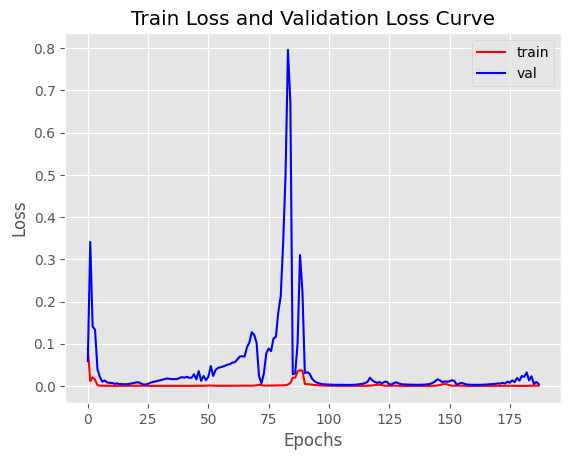

In [ ]:
model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.001526213664267048
RMSE = 0.03906678466763099
MAPE = 0.023190497242298682
R-Squared Score = 0.9771678214827985


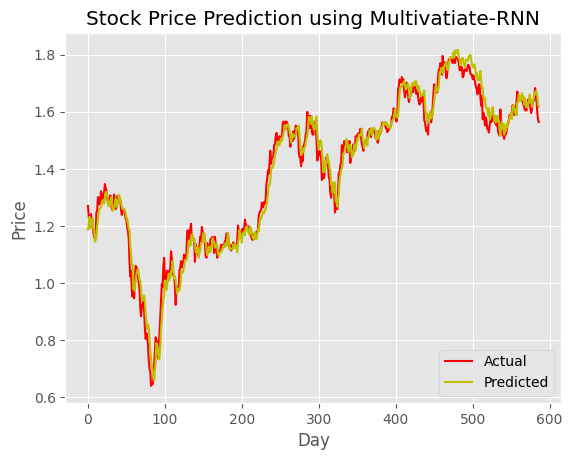

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_2(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

# Model 3: Multivariate-5-GRU


In [ ]:
import sys
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

##Data preprocessing

In [ ]:
url = 'hpg.csv'
df = pd.read_csv(url, parse_dates = True, index_col = 0)

In [ ]:
df.corr()['Close']

,Close
Close,1.000000
Open,0.999645
High,0.999852
Low,0.999825
Volume,0.520064


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.237000e+03
mean     1.693428e+07
std      1.445787e+07
min      1.690000e+03
25%      6.130000e+06
50%      1.324000e+07
75%      2.344000e+07
max      1.743500e+08
Name: Volume, dtype: float64


In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
df.head()

,Close,Open,High,Low,Volume,CMA10,SMA10,SMA50,EMA12,EMA26,MACD,RSI,CCI,%K,%D
Date,,,,,,,,,,,,,,,
2007-11-16,2530.0,2530.0,2530.0,2530.0,8390000.0,NaN,NaN,NaN,2530.000000,2530.000000,0.000000,NaN,NaN,NaN,NaN
2007-11-19,2404.5,2404.5,2404.5,2404.5,4070000.0,NaN,NaN,NaN,2510.692308,2520.703704,-10.011396,NaN,NaN,NaN,NaN
2007-11-20,2300.0,2300.0,2300.0,2300.0,1980000.0,NaN,NaN,NaN,2478.278107,2504.355281,-26.077175,NaN,NaN,NaN,NaN
2007-11-21,2383.6,2195.4,2383.6,2195.4,24590000.0,NaN,NaN,NaN,2463.712244,2495.410446,-31.698202,NaN,NaN,NaN,NaN
2007-11-22,2383.6,2383.6,2383.6,2383.6,8980000.0,NaN,NaN,NaN,2451.387283,2487.128190,-35.740907,NaN,NaN,NaN,NaN


##Train Model


In [ ]:
def fit_model_3(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Evaluate Model


In [ ]:
def evaluate_model_3(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart


In [ ]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building


In [ ]:
# Extracting the series
series = df[['Close', 'High','Low', 'RSI','MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4225, 5)
              Close     High      Low        RSI        MACD
Date                                                        
2024-11-12  27500.0  27900.0  27300.0  67.796610  199.382390
2024-11-13  27050.0  27400.0  26850.0  58.823529  187.405708
2024-11-14  26300.0  27100.0  26300.0  48.192771  116.057530
2024-11-15  25900.0  26350.0  25900.0  40.000000   26.926535
2024-11-18  25800.0  26050.0  25550.0  34.567901  -51.189504


In [ ]:

# Splitting dataset by row counts
train_data = series.iloc[:2969]
val_data = series.iloc[2970:3597]
test_data = series.iloc[3598:]

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(2969, 5) (627, 5) (627, 5)


,Close,High,Low,RSI,MACD
Date,,,,,
2007-12-05,2174.5,2195.4,2153.6,20.682830,-86.863564
2007-12-06,2195.4,2237.2,2195.4,23.325893,-86.194207
2007-12-07,2132.7,2174.5,2132.7,25.921332,-89.689221
2007-12-10,2038.6,2090.9,2038.6,26.407942,-98.911933
2007-12-11,1944.5,1975.9,1944.5,11.107174,-112.517056


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)


sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2969, 5) (627, 5) (627, 5)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 209: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 89: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 89: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 114: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 114: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 220: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 113: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 113: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 127: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 127: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 115: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 115: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 91: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 113: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 113: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Best Parameters: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}
Best RMSE Score: 0.04166991038692606
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.007650  0.087463   
1          30  [40, 35]  0.0010          32         250  0.031196  0.176625   
2          30  [40, 35]  0.0010          64         200  0.003432  0.058580   
3          30  [40, 35]  0.0010          64         250  0.003432  0.058580   
4          30  [40, 35]  0.0001          32         200  0.003485  0.059034   
5          30  [40, 35]  0.0001          32         250  0.003485  0.059034   
6          30  [40, 35]  0.0001          64         200  0.004664  0.068296   
7          30  [40, 35]  0.0001          64         250  0.004664  0.068296   
8          40  [40, 35]  0.0010          32         200  0.006884  0.082971   
9          40  [40, 35]  0.0010          32   

In [ ]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 32
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 220: early stopping


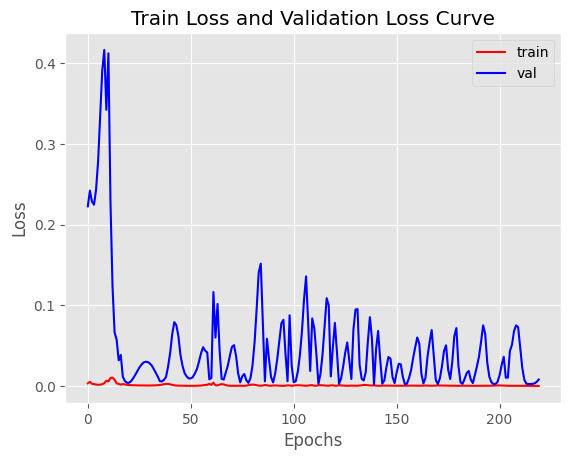

In [ ]:
model, train_error, val_error = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.001736381431654448
RMSE = 0.04166991038692606
MAPE = 0.02475628813287918
R-Squared Score = 0.9740237086394271


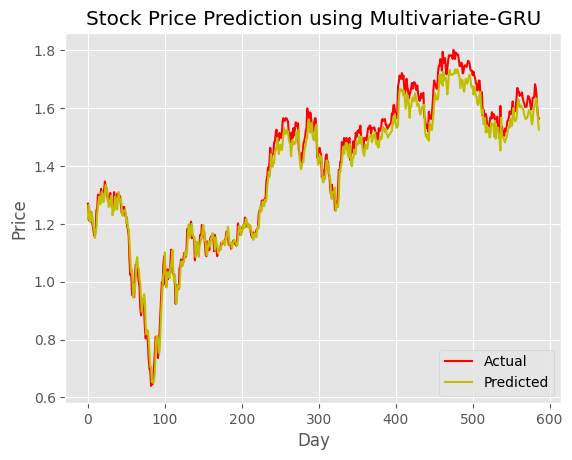

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_3(true, predicted)

In [ ]:
# Save a model
#model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
del model  #Deletes the model

# Model 4: Multivariate-5-LSTM

In [ ]:
import sys
import numpy as np
np.random.seed(1)
import random as rn
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'hpg.csv'
df = pd.read_csv(url,parse_dates = True , index_col = 0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Close,1.000000
Open,0.999645
High,0.999852
Low,0.999825
Volume,0.520064


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.237000e+03
mean     1.693428e+07
std      1.445787e+07
min      1.690000e+03
25%      6.130000e+06
50%      1.324000e+07
75%      2.344000e+07
max      1.743500e+08
Name: Volume, dtype: float64


In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()


In [ ]:
df.head()

,Close,Open,High,Low,Volume,CMA10,SMA10,SMA50,EMA12,EMA26,MACD,RSI,CCI,%K,%D
Date,,,,,,,,,,,,,,,
2007-11-16,2530.0,2530.0,2530.0,2530.0,8390000.0,NaN,NaN,NaN,2530.000000,2530.000000,0.000000,NaN,NaN,NaN,NaN
2007-11-19,2404.5,2404.5,2404.5,2404.5,4070000.0,NaN,NaN,NaN,2510.692308,2520.703704,-10.011396,NaN,NaN,NaN,NaN
2007-11-20,2300.0,2300.0,2300.0,2300.0,1980000.0,NaN,NaN,NaN,2478.278107,2504.355281,-26.077175,NaN,NaN,NaN,NaN
2007-11-21,2383.6,2195.4,2383.6,2195.4,24590000.0,NaN,NaN,NaN,2463.712244,2495.410446,-31.698202,NaN,NaN,NaN,NaN
2007-11-22,2383.6,2383.6,2383.6,2383.6,8980000.0,NaN,NaN,NaN,2451.387283,2487.128190,-35.740907,NaN,NaN,NaN,NaN


## Train Model


In [ ]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation = 'relu', return_sequences = True))
    model.add(LSTM(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [ ]:
def evaluate_model_4(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


##Plot chart

In [ ]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building

In [ ]:
# Extracting the series
series = df[['Close', 'High','Low', 'RSI','MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)


(4225, 5)


In [ ]:

# Splitting dataset by row counts
train_data = series.iloc[:2969]
val_data = series.iloc[2970:3597]
test_data = series.iloc[3598:]

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(2969, 5) (627, 5) (627, 5)


,Close,High,Low,RSI,MACD
Date,,,,,
2007-12-05,2174.5,2195.4,2153.6,20.682830,-86.863564
2007-12-06,2195.4,2237.2,2195.4,23.325893,-86.194207
2007-12-07,2132.7,2174.5,2132.7,25.921332,-89.689221
2007-12-10,2038.6,2090.9,2038.6,26.407942,-98.911933
2007-12-11,1944.5,1975.9,1944.5,11.107174,-112.517056


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2969, 5) (627, 5) (627, 5)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 235: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 98: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 98: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 124: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 124: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 104: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 104: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE Score: 0.08983524358818289
    timesteps        hl      lr  batch_size  num_epochs           MSE  \
0          30  [40, 35]  0.0010          32         200      0.229466   
1          30  [40, 35]  0.0010          32         250      0.112087   
2          30  [40, 35]  0.0010          64         200      0.509255   
3          30  [40, 35]  0.0010          64         250      0.509255   
4          30  [40, 35]  0.0001          32         200   5351.779149   
5          30  [40, 35]  0.0001          32         250   5351.779149   
6          30  [40, 35]  0.0001          64         200    623.367115   
7          30  [40, 35]  0.0001          64         250    623.367115   
8          40  [40, 35]  0.0010          32         200      0.359338   
9          40  [40, 35]  0.0010          32         250      0.359338   
10         40  [40, 35]  0.0010   

In [ ]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 32
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 104: early stopping


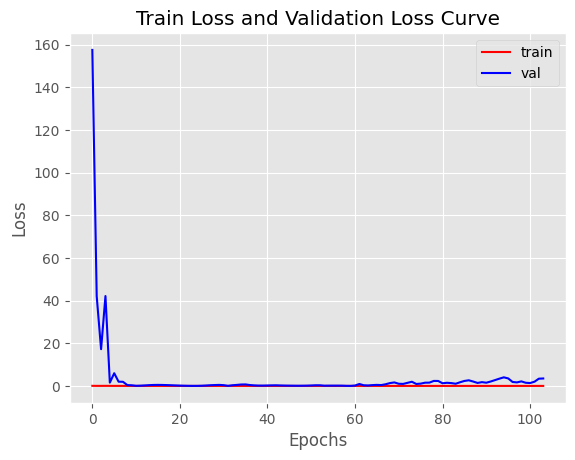

In [ ]:
model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.008070370990548154
RMSE = 0.08983524358818289
MAPE = 0.057162504582660804
R-Squared Score = 0.8802704251294527


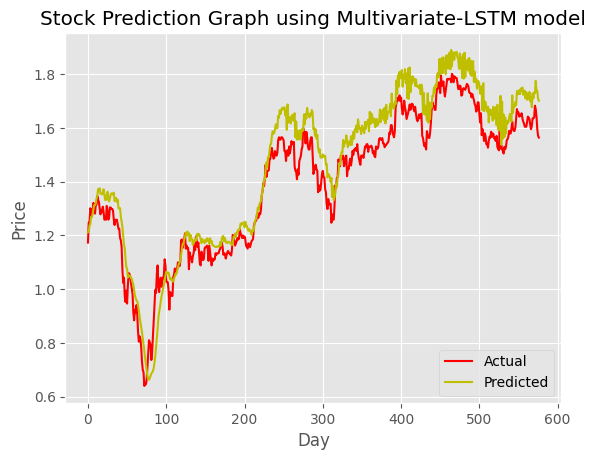

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_4(true, predicted)

In [ ]:
# Save a model
model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
del model # Deletes the model

# Model 2: Multivariate-10-RNN








In [ ]:
import sys
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
print(tf.__version__)


2.8.4


In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'hpg.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Close,1.000000
Open,0.999645
High,0.999852
Low,0.999825
Volume,0.520064


count    4.237000e+03
mean     1.693428e+07
std      1.445787e+07
min      1.690000e+03
25%      6.130000e+06
50%      1.324000e+07
75%      2.344000e+07
max      1.743500e+08
Name: Volume, dtype: float64


<Axes: >

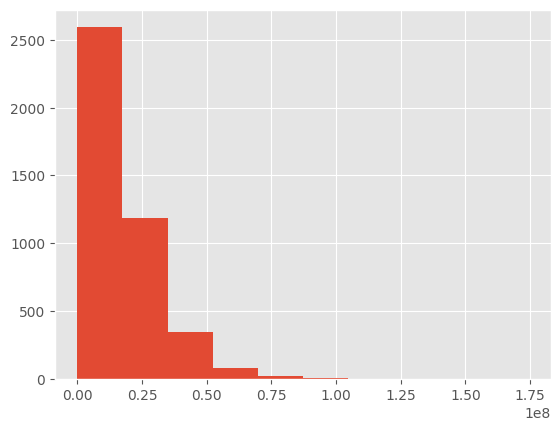

In [ ]:
# Distribution of Various Features
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df['Volume'].hist(bins = 10)

In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
print(df.head())

             Close    Open    High     Low      Volume  CMA10  SMA10  SMA50  \
Date                                                                          
2007-11-16  2530.0  2530.0  2530.0  2530.0   8390000.0    NaN    NaN    NaN   
2007-11-19  2404.5  2404.5  2404.5  2404.5   4070000.0    NaN    NaN    NaN   
2007-11-20  2300.0  2300.0  2300.0  2300.0   1980000.0    NaN    NaN    NaN   
2007-11-21  2383.6  2195.4  2383.6  2195.4  24590000.0    NaN    NaN    NaN   
2007-11-22  2383.6  2383.6  2383.6  2383.6   8980000.0    NaN    NaN    NaN   

                  EMA12        EMA26       MACD  RSI  CCI  %K  %D  
Date                                                               
2007-11-16  2530.000000  2530.000000   0.000000  NaN  NaN NaN NaN  
2007-11-19  2510.692308  2520.703704 -10.011396  NaN  NaN NaN NaN  
2007-11-20  2478.278107  2504.355281 -26.077175  NaN  NaN NaN NaN  
2007-11-21  2463.712244  2495.410446 -31.698202  NaN  NaN NaN NaN  
2007-11-22  2451.387283  2487.128190 -

## Train model

In [ ]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [ ]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200,250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_2(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart

In [ ]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## Model building

In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
series.describe()

(4185, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,4185.000000,4185.00000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000
mean,10337.085974,10333.83778,10310.134471,10192.935012,10304.296668,52.226069,12.121306,53.119156,53.099629,41.047923
std,10466.709471,10457.75125,10448.387694,10360.189119,10438.778041,18.113778,112.686485,30.800915,29.014213,417.122640
min,756.300000,783.73000,783.730000,877.530000,801.231246,0.000000,-495.676231,0.000000,0.000000,-2162.781226
25%,1948.600000,1953.40000,1953.400000,1936.602000,1947.910644,38.732631,-76.181913,25.931383,26.816934,-48.841637
50%,5277.100000,5278.42000,5191.120000,4979.118000,5137.223983,52.591823,21.844494,55.842498,55.555556,23.026417
75%,15183.600000,15078.00000,15058.490000,14827.120000,14920.230165,66.181165,101.759592,80.940819,79.992461,129.884023
max,43895.800000,43214.64000,43214.640000,41239.344000,43000.458766,100.000000,367.005458,100.000000,100.000000,2457.070901


In [ ]:
series.describe()

,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,4185.000000,4185.00000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000
mean,10337.085974,10333.83778,10310.134471,10192.935012,10304.296668,52.226069,12.121306,53.119156,53.099629,41.047923
std,10466.709471,10457.75125,10448.387694,10360.189119,10438.778041,18.113778,112.686485,30.800915,29.014213,417.122640
min,756.300000,783.73000,783.730000,877.530000,801.231246,0.000000,-495.676231,0.000000,0.000000,-2162.781226
25%,1948.600000,1953.40000,1953.400000,1936.602000,1947.910644,38.732631,-76.181913,25.931383,26.816934,-48.841637
50%,5277.100000,5278.42000,5191.120000,4979.118000,5137.223983,52.591823,21.844494,55.842498,55.555556,23.026417
75%,15183.600000,15078.00000,15058.490000,14827.120000,14920.230165,66.181165,101.759592,80.940819,79.992461,129.884023
max,43895.800000,43214.64000,43214.640000,41239.344000,43000.458766,100.000000,367.005458,100.000000,100.000000,2457.070901


In [ ]:

# Splitting dataset by row counts
train_data = series.iloc[:2969]
val_data = series.iloc[2970:3577]
test_data = series.iloc[3578:]

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(2969, 10) (607, 10) (607, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
Date,,,,,,,,,,
2008-01-28,1976.7,2036.93,2065.47,2120.558,2051.681848,35.827216,-90.753223,6.076240,4.050826,-34.470886
2008-01-29,2019.0,2036.93,2053.85,2110.338,2046.653871,29.519380,-72.133258,18.200057,9.104806,-34.524586
2008-01-30,2114.1,2036.93,2043.28,2104.530,2057.030199,39.707928,-4.046030,45.457151,23.244483,-26.586892
2008-01-31,2071.8,2047.51,2039.05,2099.966,2059.302476,38.570657,-45.668509,37.932159,33.863123,-23.439275
2008-02-01,2135.2,2055.97,2036.93,2094.998,2070.979018,43.417123,9.802115,62.942207,48.777172,-15.648529


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2969, 10) (607, 10) (607, 10)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 137: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 137: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 216: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 98: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 98: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 135: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 135: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 106: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 106: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 215: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 98: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 98: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 186: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 186: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 133: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 133: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 161: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 161: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 240: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 145: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 145: early stopping
Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.03336615366446465
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.008191  0.090502   
1          30  [40, 35]  0.0010          32         250  0.008191  0.090502   
2          30  [40, 35]  0.0010          64         200  0.007002  0.083675   
3          30  [40, 35]  0.0010          64         250  0.005470  0.073956   
4          30  [40, 35]  0.0001          32         200  0.046969  0.216724   
5          30  [40, 35]  0.0001          32         250  0.046969  0.216724   
6          30  [40, 35]  0.0001          64         200  0.001782  0.042209   
7          30  [40, 35]  0.0001          64         250  0.001782  0.042209   
8          40  [40, 35]  0.0010          32         200  0.025486  0.159642   
9          40  [40, 35]  0.0010          32   

In [ ]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 161: early stopping


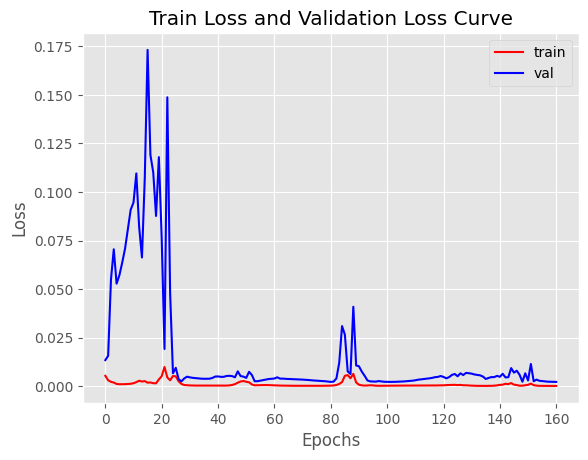

In [ ]:
model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.001113300210360668
RMSE = 0.03336615366446465
MAPE = 0.019245191792435085
R-Squared Score = 0.9839090607854719


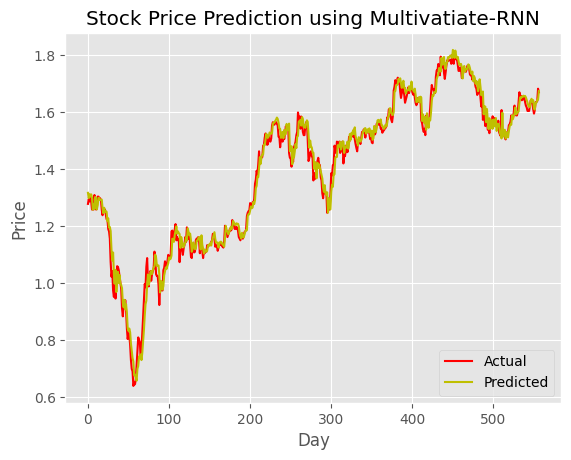

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_2(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

## Model building (8VAR)


In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'CCI', '%K', '%D']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4185, 8)
              Close    CMA10    SMA10    SMA50         EMA12         CCI  \
Date                                                                       
2024-11-06  26950.0  26935.0  26690.0  26217.4  26710.524273    5.249344   
2024-11-07  26950.0  26940.0  26740.0  26241.4  26747.366693   58.987201   
2024-11-08  27000.0  26880.0  26795.0  26267.4  26786.233356   88.135593   
2024-11-11  27700.0  26815.0  26890.0  26309.4  26926.812839  153.846154   
2024-11-12  27500.0  26765.0  26935.0  26341.4  27014.995479  170.495151   

                    %K         %D  
Date                               
2024-11-06   69.565217  37.681159  
2024-11-07   69.565217  56.521739  
2024-11-08   62.962963  67.364466  
2024-11-11  100.000000  77.509393  
2024-11-12   77.142857  80.035273  


In [ ]:
series.describe()

,Close,CMA10,SMA10,SMA50,EMA12,CCI,%K,%D
count,4185.000000,4185.00000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000,4185.000000
mean,10337.085974,10333.83778,10310.134471,10192.935012,10304.296668,12.121306,53.119156,53.099629
std,10466.709471,10457.75125,10448.387694,10360.189119,10438.778041,112.686485,30.800915,29.014213
min,756.300000,783.73000,783.730000,877.530000,801.231246,-495.676231,0.000000,0.000000
25%,1948.600000,1953.40000,1953.400000,1936.602000,1947.910644,-76.181913,25.931383,26.816934
50%,5277.100000,5278.42000,5191.120000,4979.118000,5137.223983,21.844494,55.842498,55.555556
75%,15183.600000,15078.00000,15058.490000,14827.120000,14920.230165,101.759592,80.940819,79.992461
max,43895.800000,43214.64000,43214.640000,41239.344000,43000.458766,367.005458,100.000000,100.000000


In [ ]:

# Splitting dataset by row counts
train_data = series.iloc[:2969]
val_data = series.iloc[2970:3577]
test_data = series.iloc[3578:]

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(2969, 8) (607, 8) (607, 8)


,Close,CMA10,SMA10,SMA50,EMA12,CCI,%K,%D
Date,,,,,,,,
2008-01-28,1976.7,2036.93,2065.47,2120.558,2051.681848,-90.753223,6.076240,4.050826
2008-01-29,2019.0,2036.93,2053.85,2110.338,2046.653871,-72.133258,18.200057,9.104806
2008-01-30,2114.1,2036.93,2043.28,2104.530,2057.030199,-4.046030,45.457151,23.244483
2008-01-31,2071.8,2047.51,2039.05,2099.966,2059.302476,-45.668509,37.932159,33.863123
2008-02-01,2135.2,2055.97,2036.93,2094.998,2070.979018,9.802115,62.942207,48.777172


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2969, 8) (607, 8) (607, 8)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 93: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 93: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 179: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 179: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 92: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 92: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 238: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 121: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 121: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best Parameters: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}
Best RMSE Score: 0.031662346830713395
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.085459  0.292334   
1          30  [40, 35]  0.0010          32         250  0.085459  0.292334   
2          30  [40, 35]  0.0010          64         200  0.002156  0.046428   
3          30  [40, 35]  0.0010          64         250  0.002156  0.046428   
4          30  [40, 35]  0.0001          32         200  0.004684  0.068441   
5          30  [40, 35]  0.0001          32         250  0.002274  0.047682   
6          30  [40, 35]  0.0001          64         200  0.005140  0.071695   
7          30  [40, 35]  0.0001          64         250  0.003119  0.055848   
8          40  [40, 35]  0.0010          32         200  0.045530  0.213378   
9          40  [40, 35]  0.0010          32         250  0.045530  0.21

In [ ]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 238: early stopping


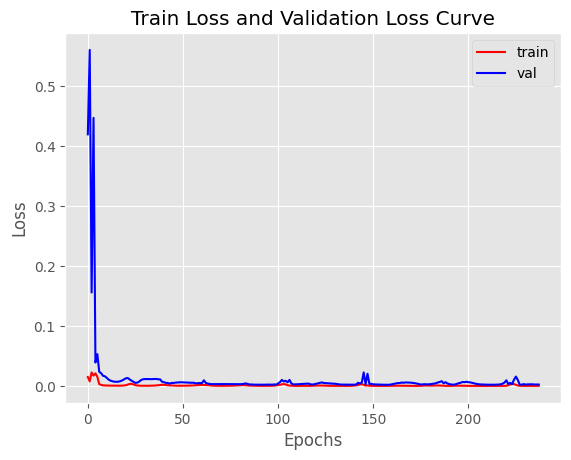

In [ ]:
model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.0010025042068283864
RMSE = 0.031662346830713395
MAPE = 0.018622240808365942
R-Squared Score = 0.9852771951506899


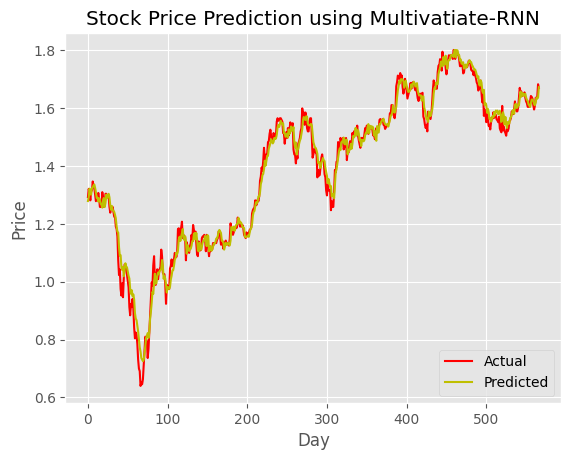

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_2(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

# Model 3: Multivariate-10-GRU


In [ ]:
import sys
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

##Data preprocessing

In [ ]:
url = 'hpg.csv'
df = pd.read_csv(url, parse_dates = True, index_col = 0)

In [ ]:
df.corr()['Close']

,Close
Close,1.000000
Open,0.999645
High,0.999852
Low,0.999825
Volume,0.520064


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.237000e+03
mean     1.693428e+07
std      1.445787e+07
min      1.690000e+03
25%      6.130000e+06
50%      1.324000e+07
75%      2.344000e+07
max      1.743500e+08
Name: Volume, dtype: float64


In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [ ]:
df.head()

,Close,Open,High,Low,Volume,CMA10,SMA10,SMA50,EMA12,EMA26,MACD,RSI,CCI,%K,%D
Date,,,,,,,,,,,,,,,
2007-11-16,2530.0,2530.0,2530.0,2530.0,8390000.0,NaN,NaN,NaN,2530.000000,2530.000000,0.000000,NaN,NaN,NaN,NaN
2007-11-19,2404.5,2404.5,2404.5,2404.5,4070000.0,NaN,NaN,NaN,2510.692308,2520.703704,-10.011396,NaN,NaN,NaN,NaN
2007-11-20,2300.0,2300.0,2300.0,2300.0,1980000.0,NaN,NaN,NaN,2478.278107,2504.355281,-26.077175,NaN,NaN,NaN,NaN
2007-11-21,2383.6,2195.4,2383.6,2195.4,24590000.0,NaN,NaN,NaN,2463.712244,2495.410446,-31.698202,NaN,NaN,NaN,NaN
2007-11-22,2383.6,2383.6,2383.6,2383.6,8980000.0,NaN,NaN,NaN,2451.387283,2487.128190,-35.740907,NaN,NaN,NaN,NaN


##Train Model


In [ ]:
def fit_model_3(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

##Evaluate Model


In [ ]:
def evaluate_model_3(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200,250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart


In [ ]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building


In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4185, 10)
              Close    CMA10    SMA10    SMA50         EMA12        RSI  \
Date                                                                      
2024-11-06  26950.0  26935.0  26690.0  26217.4  26710.524273  44.642857   
2024-11-07  26950.0  26940.0  26740.0  26241.4  26747.366693  50.000000   
2024-11-08  27000.0  26880.0  26795.0  26267.4  26786.233356  55.319149   
2024-11-11  27700.0  26815.0  26890.0  26309.4  26926.812839  67.796610   
2024-11-12  27500.0  26765.0  26935.0  26341.4  27014.995479  67.796610   

                   CCI          %K         %D        MACD  
Date                                                       
2024-11-06    5.249344   69.565217  37.681159   73.087510  
2024-11-07   58.987201   69.565217  56.521739   86.777097  
2024-11-08   88.135593   62.962963  67.364466  100.502249  
2024-11-11  153.846154  100.000000  77.509393  165.950703  
2024-11-12  170.495151   77.142857  80.035273  199.382390  


In [ ]:

# Splitting dataset by row counts
train_data = series.iloc[:2969]
val_data = series.iloc[2970:3577]
test_data = series.iloc[3578:]

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(2969, 10) (607, 10) (607, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
Date,,,,,,,,,,
2008-01-28,1976.7,2036.93,2065.47,2120.558,2051.681848,35.827216,-90.753223,6.076240,4.050826,-34.470886
2008-01-29,2019.0,2036.93,2053.85,2110.338,2046.653871,29.519380,-72.133258,18.200057,9.104806,-34.524586
2008-01-30,2114.1,2036.93,2043.28,2104.530,2057.030199,39.707928,-4.046030,45.457151,23.244483,-26.586892
2008-01-31,2071.8,2047.51,2039.05,2099.966,2059.302476,38.570657,-45.668509,37.932159,33.863123,-23.439275
2008-02-01,2135.2,2055.97,2036.93,2094.998,2070.979018,43.417123,9.802115,62.942207,48.777172,-15.648529


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)


sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2969, 10) (607, 10) (607, 10)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 134: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 134: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 248: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 120: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 120: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 123: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 123: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 246: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 181: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 181: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 147: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 147: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 214: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 222: early stopping
Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE Score: 0.03328116184904176
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.025301  0.159062   
1          30  [40, 35]  0.0010          32         250  0.025301  0.159062   
2          30  [40, 35]  0.0010          64         200  0.007611  0.087238   
3          30  [40, 35]  0.0010          64         250  0.006359  0.079743   
4          30  [40, 35]  0.0001          32         200  0.001108  0.033281   
5          30  [40, 35]  0.0001          32         250  0.001582  0.039779   
6          30  [40, 35]  0.0001          64         200  0.001427  0.037773   
7          30  [40, 35]  0.0001          64         250  0.002676  0.051731   
8          40  [40, 35]  0.0010          32         200  0.015515  0.124559   
9          40  [40, 35]  0.0010          32  

In [ ]:
timesteps = 30
hl = [40,35]
lr = 1e-4
batch_size = 32
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


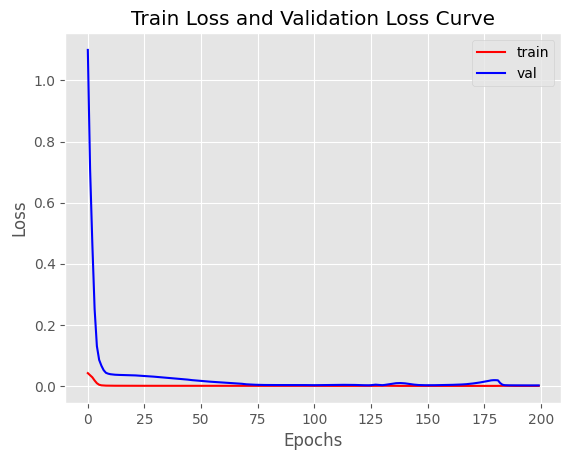

In [ ]:
model, train_error, val_error = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.0011076357340221127
RMSE = 0.03328116184904176
MAPE = 0.019498827852177766
R-Squared Score = 0.983577702750924


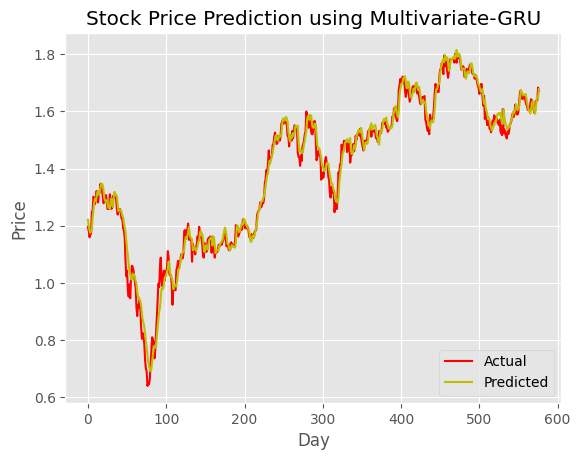

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_3(true, predicted)

In [ ]:
# Save a model
#model.save('MV3-GRU_40_[40,35]_1e-4_64.h5')
del model  #Deletes the model

## 8VAR


In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'CCI', '%K', '%D']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4185, 8)
              Close    CMA10    SMA10    SMA50         EMA12         CCI  \
Date                                                                       
2024-11-06  26950.0  26935.0  26690.0  26217.4  26710.524273    5.249344   
2024-11-07  26950.0  26940.0  26740.0  26241.4  26747.366693   58.987201   
2024-11-08  27000.0  26880.0  26795.0  26267.4  26786.233356   88.135593   
2024-11-11  27700.0  26815.0  26890.0  26309.4  26926.812839  153.846154   
2024-11-12  27500.0  26765.0  26935.0  26341.4  27014.995479  170.495151   

                    %K         %D  
Date                               
2024-11-06   69.565217  37.681159  
2024-11-07   69.565217  56.521739  
2024-11-08   62.962963  67.364466  
2024-11-11  100.000000  77.509393  
2024-11-12   77.142857  80.035273  


In [ ]:

# Splitting dataset by row counts
train_data = series.iloc[:2969]
val_data = series.iloc[2970:3577]
test_data = series.iloc[3578:]

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(2969, 8) (607, 8) (607, 8)


,Close,CMA10,SMA10,SMA50,EMA12,CCI,%K,%D
Date,,,,,,,,
2008-01-28,1976.7,2036.93,2065.47,2120.558,2051.681848,-90.753223,6.076240,4.050826
2008-01-29,2019.0,2036.93,2053.85,2110.338,2046.653871,-72.133258,18.200057,9.104806
2008-01-30,2114.1,2036.93,2043.28,2104.530,2057.030199,-4.046030,45.457151,23.244483
2008-01-31,2071.8,2047.51,2039.05,2099.966,2059.302476,-45.668509,37.932159,33.863123
2008-02-01,2135.2,2055.97,2036.93,2094.998,2070.979018,9.802115,62.942207,48.777172


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)


sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2969, 8) (607, 8) (607, 8)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 126: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 126: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 145: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 145: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 121: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 121: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 206: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 139: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 139: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best Parameters: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}
Best RMSE Score: 0.036926435923040686
    timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200  0.002359  0.048575   
1          30  [40, 35]  0.0010          32         250  0.002359  0.048575   
2          30  [40, 35]  0.0010          64         200  0.018864  0.137346   
3          30  [40, 35]  0.0010          64         250  0.018864  0.137346   
4          30  [40, 35]  0.0001          32         200  0.003154  0.056157   
5          30  [40, 35]  0.0001          32         250  0.002197  0.046877   
6          30  [40, 35]  0.0001          64         200  0.010321  0.101593   
7          30  [40, 35]  0.0001          64         250  0.006861  0.082831   
8          40  [40, 35]  0.0010          32         200  0.082091  0.286514   
9          40  [40, 35]  0.0010          32         250  0.082091  0.28

In [ ]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


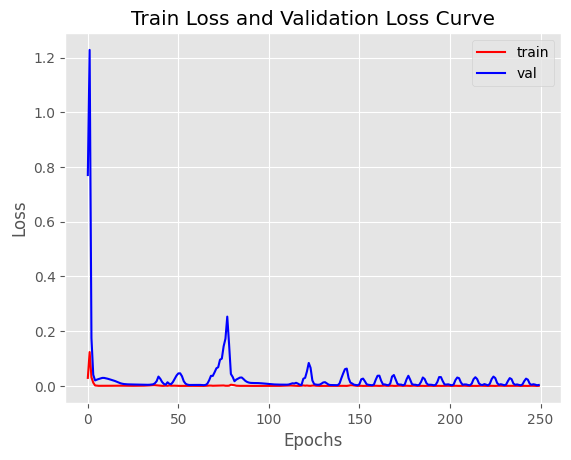

In [ ]:
model, train_error, val_error = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.0013635616699784296
RMSE = 0.036926435923040686
MAPE = 0.02126052375499666
R-Squared Score = 0.9799746951380839


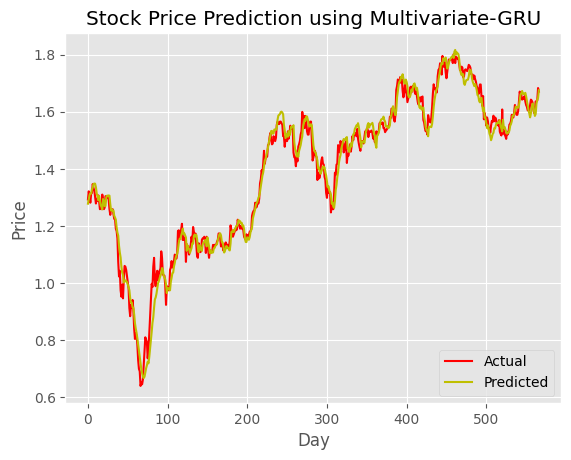

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_3(true, predicted)

In [ ]:
# Save a model
model.save('MV3-RNN_30_[50,45]_1e-3_32.h5')
del model

# Model 4: Multivariate-10-LSTM

In [ ]:
import sys
import numpy as np
np.random.seed(1)
import random as rn
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [ ]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  #điều kiện là trên tập var_loss, cải thiện < min_delta -> ngừng, patience: số vòng lặp tiếp tục chạy từ khi 0 có cải thiện trc khi dừng, 1:tbao quá trình dừng sớm, mode: chỉ định cách ktra cải thiện
callbacks_list = [earlystop]                                                                          #lưu cái earlystop vào, để sau này dùng lúc huấn luyện

## Data preprocessing

In [ ]:
# Loading the dataset
url = 'hpg.csv'
df = pd.read_csv(url,parse_dates = True , index_col = 0)

In [ ]:
# Correlation matrix
df.corr()['Close']

,Close
Close,1.000000
Open,0.999645
High,0.999852
Low,0.999825
Volume,0.520064


In [ ]:
print(df.describe().Volume)
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    4.237000e+03
mean     1.693428e+07
std      1.445787e+07
min      1.690000e+03
25%      6.130000e+06
50%      1.324000e+07
75%      2.344000e+07
max      1.743500e+08
Name: Volume, dtype: float64


In [ ]:
# Tính CMA10
df['CMA10'] = df['Close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['Close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['Close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['Close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['High'] + df['Low'] + df['Close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()

df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()


In [ ]:
df.head()

,Close,Open,High,Low,Volume,CMA10,SMA10,SMA50,EMA12,EMA26,MACD,RSI,CCI,%K,%D
Date,,,,,,,,,,,,,,,
2007-11-16,2530.0,2530.0,2530.0,2530.0,8390000.0,NaN,NaN,NaN,2530.000000,2530.000000,0.000000,NaN,NaN,NaN,NaN
2007-11-19,2404.5,2404.5,2404.5,2404.5,4070000.0,NaN,NaN,NaN,2510.692308,2520.703704,-10.011396,NaN,NaN,NaN,NaN
2007-11-20,2300.0,2300.0,2300.0,2300.0,1980000.0,NaN,NaN,NaN,2478.278107,2504.355281,-26.077175,NaN,NaN,NaN,NaN
2007-11-21,2383.6,2195.4,2383.6,2195.4,24590000.0,NaN,NaN,NaN,2463.712244,2495.410446,-31.698202,NaN,NaN,NaN,NaN
2007-11-22,2383.6,2383.6,2383.6,2383.6,8980000.0,NaN,NaN,NaN,2451.387283,2487.128190,-35.740907,NaN,NaN,NaN,NaN


## Train Model


In [ ]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation = 'relu', return_sequences = True))
    model.add(LSTM(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

## Evaluate Model

In [ ]:
def evaluate_model_4(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

##Grid Search: Tìm kiếm siêu tham số tối ưu.

In [ ]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200,250],  # Số epoch
}

In [ ]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


##Plot chart

In [ ]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [ ]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

##Model building

In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)


(4185, 10)


In [ ]:

# Splitting dataset by row counts
train_data = series.iloc[:2969]
val_data = series.iloc[2970:3577]
test_data = series.iloc[3578:]

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(2969, 10) (607, 10) (607, 10)


,Close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
Date,,,,,,,,,,
2008-01-28,1976.7,2036.93,2065.47,2120.558,2051.681848,35.827216,-90.753223,6.076240,4.050826,-34.470886
2008-01-29,2019.0,2036.93,2053.85,2110.338,2046.653871,29.519380,-72.133258,18.200057,9.104806,-34.524586
2008-01-30,2114.1,2036.93,2043.28,2104.530,2057.030199,39.707928,-4.046030,45.457151,23.244483,-26.586892
2008-01-31,2071.8,2047.51,2039.05,2099.966,2059.302476,38.570657,-45.668509,37.932159,33.863123,-23.439275
2008-02-01,2135.2,2055.97,2036.93,2094.998,2070.979018,43.417123,9.802115,62.942207,48.777172,-15.648529


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2969, 10) (607, 10) (607, 10)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 140: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 140: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 165: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 165: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 143: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 143: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 85: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 84: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 84: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 202: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 130: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 110: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 110: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 100: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 100: early stopping
Best Parameters: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}
Best RMSE Score: 0.05688737528802692
    timesteps        hl      lr  batch_size  num_epochs        MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200   0.173866  0.416972   
1          30  [40, 35]  0.0010          32         250   0.173866  0.416972   
2          30  [40, 35]  0.0010          64         200   0.004892  0.069942   
3          30  [40, 35]  0.0010          64         250   0.004892  0.069942   
4          30  [40, 35]  0.0001          32         200   0.227460  0.476928   
5          30  [40, 35]  0.0001          32         250   0.227460  0.476928   
6          30  [40, 35]  0.0001          64         200   0.020595  0.143511   
7          30  [40, 35]  0.0001          64         250   0.020595  0.143511   
8          40  [40, 35]  0.0010          32         200   0.030028  0.173285   
9          40  [40, 35]  0.0010     

In [ ]:
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


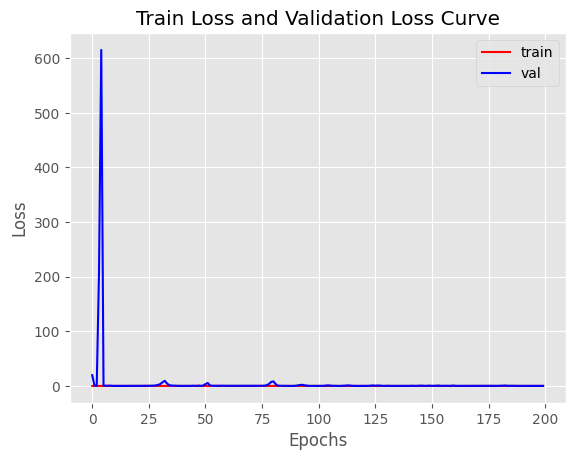

In [ ]:
model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.003236173467160816
RMSE = 0.05688737528802692
MAPE = 0.03259984440621925
R-Squared Score = 0.9524734658558093


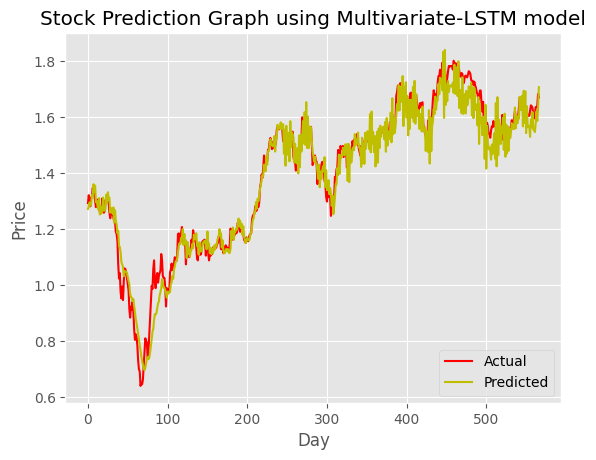

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_4(true, predicted)

In [ ]:
# Save a model
model.save('MV3-LSTM_50_[40,35]_1e-3_64.h5')
del model # Deletes the model

## 8 VAR


In [ ]:
# Extracting the series
series = df[['Close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'CCI', '%K', '%D']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(4185, 8)
              Close    CMA10    SMA10    SMA50         EMA12         CCI  \
Date                                                                       
2024-11-06  26950.0  26935.0  26690.0  26217.4  26710.524273    5.249344   
2024-11-07  26950.0  26940.0  26740.0  26241.4  26747.366693   58.987201   
2024-11-08  27000.0  26880.0  26795.0  26267.4  26786.233356   88.135593   
2024-11-11  27700.0  26815.0  26890.0  26309.4  26926.812839  153.846154   
2024-11-12  27500.0  26765.0  26935.0  26341.4  27014.995479  170.495151   

                    %K         %D  
Date                               
2024-11-06   69.565217  37.681159  
2024-11-07   69.565217  56.521739  
2024-11-08   62.962963  67.364466  
2024-11-11  100.000000  77.509393  
2024-11-12   77.142857  80.035273  


In [ ]:

# Splitting dataset by row counts
train_data = series.iloc[:2969]
val_data = series.iloc[2970:3577]
test_data = series.iloc[3578:]

# Output the shapes to confirm the split
print(train_data.shape, val_data.shape, test_data.shape)
train_data.head()

(2969, 8) (607, 8) (607, 8)


,Close,CMA10,SMA10,SMA50,EMA12,CCI,%K,%D
Date,,,,,,,,
2008-01-28,1976.7,2036.93,2065.47,2120.558,2051.681848,-90.753223,6.076240,4.050826
2008-01-29,2019.0,2036.93,2053.85,2110.338,2046.653871,-72.133258,18.200057,9.104806
2008-01-30,2114.1,2036.93,2043.28,2104.530,2057.030199,-4.046030,45.457151,23.244483
2008-01-31,2071.8,2047.51,2039.05,2099.966,2059.302476,-45.668509,37.932159,33.863123
2008-02-01,2135.2,2055.97,2036.93,2094.998,2070.979018,9.802115,62.942207,48.777172


In [ ]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)


sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2969, 8) (607, 8) (607, 8)


In [ ]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 105: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 105: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 94: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 94: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 109: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 109: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 171: early stopping
Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 171: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 104: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 104: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 107: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 107: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 82: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 140: early stopping
Training with params: {'timesteps': 40, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 140: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 107: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 107: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 180: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 81: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 200}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Training with params: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 83: early stopping
Best Parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE Score: 0.11115776371226285
    timesteps        hl      lr  batch_size  num_epochs        MSE      RMSE  \
0          30  [40, 35]  0.0010          32         200   0.012356  0.111158   
1          30  [40, 35]  0.0010          32         250   0.012356  0.111158   
2          30  [40, 35]  0.0010          64         200   1.011471  1.005719   
3          30  [40, 35]  0.0010          64         250   1.011471  1.005719   
4          30  [40, 35]  0.0001          32         200   0.271012  0.520588   
5          30  [40, 35]  0.0001          32         250   0.271012  0.520588   
6          30  [40, 35]  0.0001          64         200   0.230702  0.480314   
7          30  [40, 35]  0.0001          64         250   0.230702  0.480314   
8          40  [40, 35]  0.0010          32         200   5.848627  2.418394   
9          40  [40, 35]  0.0010      

In [ ]:
timesteps = 30
hl = [40,35]
lr = 1e-3
batch_size = 32
num_epochs = 200

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 105: early stopping


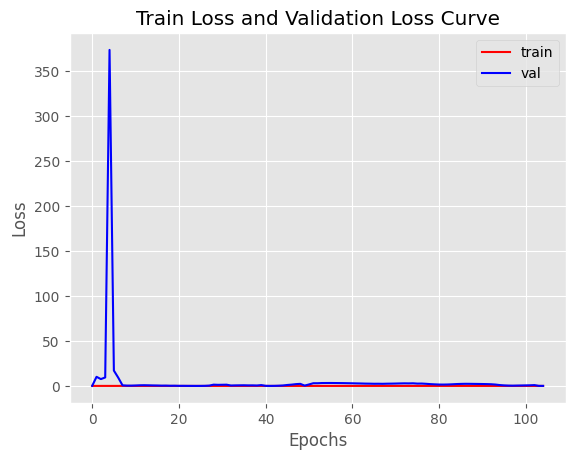

In [ ]:
model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

MSE = 0.01235604843351126
RMSE = 0.11115776371226285
MAPE = 0.07348085606421717
R-Squared Score = 0.8168037614114659


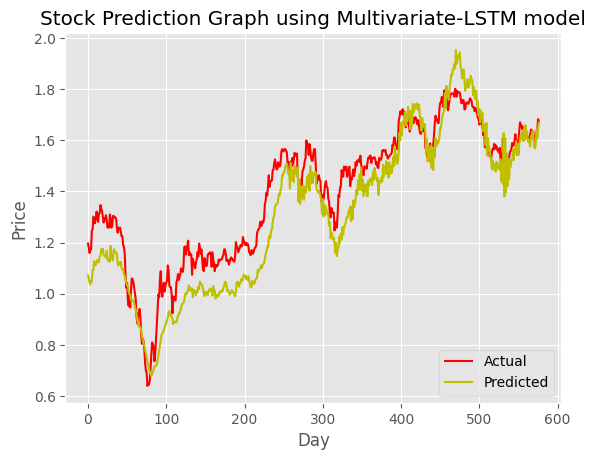

In [ ]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))
plot_data_4(true, predicted)

In [ ]:
del model